Note for exporting:

    Need to export to html.
    
    Can't then make the html into a pdf without plots not fitting

In [1]:
import os 
ROOT = os.getenv( "HOME" )
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
sns.set(style="whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Band, Span, Plot
# output to static HTML 
output_notebook()

import datetime

pd.set_option('precision', 2)
pd.options.display.max_rows = 999
pd.options.plotting.matplotlib.register_converters = True

Loading BokehJS ...

In [2]:
PLACE = 'North Hollywood'
PLACES = [  'North Hollywood', 'Burbank', 'Encino', 'Glendale', 'Sherman Oaks',  'Studio City',   'Van Nuys',  'Valley Glen',]

# numbers are small or null before this
start_date = '2020-03-24'

county_url = 'https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv'
locale_url = 'https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-place-totals.csv'
hospital_url = 'https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/cdph-hospital-patient-county-totals.csv'

# Download and prepare data

In [3]:
def calc_daily_new(locales, place, replace_neg=False):
    """
    Returns a dataframe with the change between each day
    """
    d = locales.loc[place].copy(deep=True)
    try:
        d.drop(['county'], axis=1, inplace=True)
    except:
        pass
    d = d - d.shift(1)
    if replace_neg:
        return d.clip(lower=0)
    return d

def calc_daily_growth(locales, place, prevent_negatives=True):
    """
    Calculates the daily growth rate
    
    If prevent_negatives is True, it will filter out any negative
    growth values (as sometimes happens when negative cases /deaths 
    have been added to the data to adjust totals) 
    """
    
    daily =  calc_daily_new(locales, place)
    d = daily / daily.shift(1) 
    
    # remove any infinite values 
    d = d.mask(np.isinf(d))
    
    # remove any negative values
    if prevent_negatives:
        d = d[d.confirmed_cases >= 0]
    
    return d


def plot_growth_rate(growth_frame, place):
    fig, axes = plt.subplots(figsize=(10, 4))
    title = "{} Daily growth rate".format(place)
    growth_frame.plot(kind='bar', title=title, ax=axes)
    ticklabels = [i.strftime("%b-%d") for i, row in growth_frame.iterrows()]
    axes.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
    # fig.autofmt_xdate();
    axes.axhline(y=1, color='r')
    fig.tight_layout()

    
# noho_growth_rate

In [4]:
counties = pd.read_csv(county_url)
counties.date = pd.to_datetime(counties.date)
counties.set_index('date', inplace=True)
counties.drop(['fips'], axis=1,inplace=True)
# len(counties)

# LA County data
lac = counties[counties.county == 'Los Angeles'].loc[start_date :].copy(deep=True)
lac.drop(['county'], axis=1, inplace=True)
lac_daily_new = lac[['new_confirmed_cases', 'new_deaths']]
lac_cum = lac[[ 'confirmed_cases', 'deaths']]
lac_growth_rate = lac_daily_new / lac_daily_new.shift(1)

# Locale data
locales = pd.read_csv(locale_url)
locales.drop([  'fips',  'note', 'x', 'y'], axis=1, inplace=True)
locales.date = pd.to_datetime(locales.date)
locales.set_index(['place', 'date'], inplace=True)
la_locales = locales[locales.county == 'Los Angeles'].copy(deep=True)
la_locales.drop([ 'county'], axis=1, inplace=True)
la_locale_names = list(la_locales.index.get_level_values(0))


# NoHo data
noho = la_locales.loc['North Hollywood'].copy(deep=True)

# hospitalizations 
hosp = pd.read_csv(hospital_url)
hosp.date = pd.to_datetime(hosp.date)
hosp.drop(['fips'], axis=1, inplace=True)
hosp_lac = hosp[hosp.county == 'Los Angeles'].drop(['county'], axis=1).copy(deep=True)
hosp_lac.set_index('date', inplace=True)
hosp_lac['total_patients'] = hosp_lac.positive_patients + hosp_lac.suspected_patients
hosp_lac['total_icu'] = hosp_lac.icu_positive_patients + hosp_lac.icu_suspected_patients
new_hosp_lac = hosp_lac - hosp_lac.shift(1)
new_hosp_lac.dropna(inplace=True)

# growth rates
# dict version for easiest access to individual frames
locale_growth_rates = { place : calc_daily_growth(locales, place) for place in PLACES}
# combined version 
fms = []
for place, frame in locale_growth_rates.items():
    f = frame.copy(deep=True)
    f['locale'] = place
    fms.append(f)
growth_rate_frame = pd.concat(fms)

noho_growth_rate = locale_growth_rates.get(PLACE)
noho_growth_rate = noho_growth_rate[noho_growth_rate.confirmed_cases >= 0]


# Daily new

In [5]:
def plot_daily(frame, field_name, title_word, place='(LAC)'):
    """
    Plots the desired field's daily values as a vertical bar graph
    with a 7-day moving average line
    
    """
    TOOLTIPS = [
        ("cases", "@new_confirmed_cases"),
        ("date", "@date")
#         ("(x,y)", "($x, $y)"),
        #     ("desc", "@desc"),
    ]

    p = figure(
        plot_width=1000,
        plot_height=400,
        title=f"Daily new {title_word} {place}",
        x_axis_type='datetime',
               tooltips=TOOLTIPS)

    source = ColumnDataSource(frame.reset_index())
    source2 = ColumnDataSource(frame.rolling(window='7D').mean().reset_index())

    # add a circle renderer with a size, color, and alpha
    # p.circle(x='date', y='new_confirmed_cases', size=10, color="navy", source=source, alpha=0.5)
    p.vbar(
        x='date',
        top=field_name,
        color="green",
        width=0.4,
        source=source,
        alpha=0.8,
        legend_label=f'Daily new {title_word}')
    p.line(
        x='date',
        y=field_name,
        line_width=5,
        color="navy",
        source=source2,
        alpha=0.3,
        legend_label='7-day rolling avg')
 
    # df['lower'] = df.new_confirmed_cases.mean() - df.new_confirmed_cases.std()
    # df['upper'] = df.new_confirmed_cases.mean() + df.new_confirmed_cases.std()
    # band = Band(base='x', lower='lower', upper='upper', source=source, level='underlay',
    #             fill_alpha=1.0, line_width=1, line_color='black')
    # p.add_layout(band)

    # show the results
    show(p)

## LA County

In [6]:
cases_d = {
    'frame': lac_daily_new,
    'field_name': 'new_confirmed_cases',
    'title_word': 'cases',
    'place': '-- LA County'
}

deaths_d = {
    'frame': lac_daily_new,
    'field_name': 'new_deaths',
    'title_word': 'deaths',
    'place': '-- LA County'
}

plot_daily(**cases_d)
plot_daily(**deaths_d)

The above represents the daily new case  and death counts for LA County. It would be nice if these lines were sloping downward....

Notes

    The spike in late April is when testing finally ramped up.

    The data has some day-of-week seasonality for both cases and deaths. The low numbers generally occur on Sundays and Mondays. I've taken a 7 day rolling average to smooth those out. 

In [7]:
pos_patients_d = {
    'frame': new_hosp_lac,
    'field_name': 'total_patients',
    'title_word': 'hospitalizations (suspected and confirmed cases)',
    'place': '-- LA County'
}
pos_icu_d = {
    'frame': new_hosp_lac,
    'field_name': 'total_icu',
    'title_word': 'patients in ICU (suspected and confirmed cases)',
    'place': '-- LA County'
}
plot_daily(**pos_patients_d)
plot_daily(**pos_icu_d)

The above charts represent the difference between the number of hospitalized covid19 patients on a given day and the count of the day before. 

Thus starting around May 1st the number of hospitalized patients tended to decline each day; in early June the numbers begin to creep back up.

Notes

    - A negative number on a given day means that more patients died / were discharged than were newly admitted.

    - The dataset contains separate fields for patients with positive tests and suspected patients. After the early days, the counts of suspected patients (both hospitalized and in icu) dropped off as testing got better. Thus I've assumed that most suspected patients were in fact infected and combined the counts of suspected and confirmed cases. 

## NoHo

In [8]:
noho_new = calc_daily_new(locales, PLACE)
cases_d = {
    'frame': noho_new,
    'field_name': 'confirmed_cases',
    'title_word': 'cases',
    'place': '-- NoHo'
}

plot_daily(**cases_d)

The above represents the daily new cases in North Hollywood. The numbers are small and noisy.

Notes

    The spike in late April is when testing finally ramped up.

    The data has some day-of-week seasonality for both cases. The low numbers generally occur on Sundays and Mondays. I've taken a 7 day rolling average to smooth those out. 
    
    The day with negative new cases in early April is likely due to a correction to the totals. Either that or time temporarily and locally ran backwards.

## Neighboring locales

The following are daily new case counts for other south SF Valley neighborhoods.

I've included the North Hollywood case counts (from the above chart) for reference.

In [9]:
def plot_daily_locales(localities_frame, place, noho_new=None):
    """
    Plots the new case counts for localities as a vertical bar graph
    with a 7-day moving average line and a representation of north hollywood's trend 
    
    """
    field_name = 'confirmed_cases'

    p = figure(
        plot_width=1000,
        plot_height=400,
        title=f"Daily new cases --{place}",
        x_axis_type='datetime')

    d_new = calc_daily_new(localities_frame, place, replace_neg=True)
    source = ColumnDataSource(d_new.reset_index())
    source2 = ColumnDataSource(d_new.rolling(window='7D').mean().reset_index())

    p.vbar(
        x='date',
        top=field_name,
        color="green",
        width=0.4,
        source=source,
        alpha=0.8,
        legend_label=f'Daily new cases')
    p.line(
        x='date',
        y=field_name,
        line_width=5,
        color="navy",
        source=source2,
        alpha=0.3,
        legend_label=f'7-day rolling avg ({place})')

    if noho_new is not None:
        source3 = ColumnDataSource(
            noho_new.rolling(window='7D').mean().reset_index())
        p.line(
            x='date',
            y=field_name,
            line_width=5,
            color="red",
            source=source3,
            alpha=0.2,
            legend_label=f'7-day rolling avg (NoHo)')

    show(p)

In [10]:
for place in PLACES:
    if place != PLACE:
        plot_daily_locales(locales, place, noho_new=noho_new)

# Cumulative counts

## Cases (LA County)

Putting everything on a log scale allows us to see whether things are accelerating. The more diagonal the line, the more exponential the growth (i.e., a bigger exponent).

In [11]:
source = ColumnDataSource(lac)
p = figure(plot_width=1000, plot_height=400, x_axis_type='datetime',
           y_axis_type='log',
           title=f"Cumulative cases (log scale)", 
           title_location='above')

p.circle(x='date', 
         y='confirmed_cases', 
         size=5, 
         color="navy", 
         source=source, 
         alpha=0.2, 
         legend_label='Cases')

p.line(x='date', 
         y='confirmed_cases', 
         line_width=5, 
         color="navy", 
         source=source, 
         alpha=0.5, 
         legend_label='Cases')

p.legend.location = 'bottom_right'

show(p)

## Deaths (LA County)

In [12]:
source = ColumnDataSource(lac)
p = figure(plot_width=1000, plot_height=400, x_axis_type='datetime',
           y_axis_type='log',
           title=f"Cumulative deaths (log scale)", 
           title_location='above')

p.circle(x='date', 
         y='deaths', 
         size=5, 
         color="navy", 
         source=source, 
         alpha=0.2, 
         legend_label='Deaths')

p.line(x='date', 
         y='deaths', 
         line_width=5, 
         color="navy", 
         source=source, 
         alpha=0.5, 
         legend_label='Deaths')

p.legend.location = 'bottom_right'

show(p)

# Growth rates

We also can look at the growth rate from day-to-day. This is the number of new cases today divided by the number of new cases yesterday. For example:

    Yesterday: 10 new
    
    Today: 5 new
    
    Growth rate: 5 / 10 = 0.5
    
and

    Yesterday: 5 new
    
    Today: 10 new
    
    Growth rate: 2.0

If the growth rate is greater than 1, things are getting increasingly worse. If it is 1, they are staying the same. If it is less than 1, it is slowing. Thus in the following plots we want to see values below the red line. 



I've labeled the following plots 'trimmed' to indicate that outlier daily growth values about 5.0 are not represented by points. It's easy to get that kind of noise given the relatively small numbers in the local case data. The outlier values are included in the calculation of the trend lies.

---

NB, the rate cannot go below 0 because there can't be negative new cases. Sometimes the raw data contains negative values to make a correction to the totals. Since they comprise a very small number of cases, I've dropped all negative values.

## Deaths growth rate

In [13]:
# need to trim so plot is readable
top_limit=5; bottom_limit=-5
trm = lac_growth_rate[lac_growth_rate.new_deaths >= bottom_limit] # and noho_growth_rate.confirmed_cases <= top_limit]
trm = trm[trm.new_deaths <= top_limit]
source = ColumnDataSource(trm.reset_index())
# not using the trimmed source to compute trend
source2 = ColumnDataSource(lac_growth_rate.rolling(window='7D').mean().reset_index())

p = figure(plot_width=1000, plot_height=400, x_axis_type='datetime', 
           title=f"Daily death growth rate (trimmed)", 
           title_location='above')

p.circle(x='date', 
         y='new_deaths', 
         size=5, 
         color="navy", 
         source=source, 
         alpha=0.8, 
         legend_label='daily death growth rate')

p.line(
    x='date',
    y='new_deaths',
    line_width=5,
    color="navy",
    source=source2,
    alpha=0.5,
    legend_label=f'7-day rolling avg')

ln = Span(location=1, dimension='width', line_color='red', line_dash='dashed', line_width=3)
p.add_layout(ln)
p.legend.location = 'bottom_right'
show(p)

## Local growth rates

The following represent the growth rates of cases in various areas. To get a sense of whether an area is growing faster or slower than other areas I have overlaid the LA County and North Hollywood growth rates. 

NB, these plots shouldn't be taken terribly seriously. The number of cases in each area is relatively small. Thus it's easy to get outsized effects (e.g., if 1 case was diagnosed yesterday and 5 were diagnosed today, the growth rate would be 5). Still, taken as a whole they may be somewhat useful.

In [14]:
def plot_locale_growth(growth_frame, place, noho_growth_rate=None, lac_growth_rate=None, top_limit=5, bottom_limit=0):
    """
    Plots the growth rates for localities as a dot plot 
    with a 7-day moving average line and a representation of north hollywood's trend 
    
    """
    # trim the values so the plot will be readable
    trm = growth_frame[growth_frame.confirmed_cases >= bottom_limit] # and noho_growth_rate.confirmed_cases <= top_limit]
    trm = trm[trm.confirmed_cases <= top_limit]
    source = ColumnDataSource(trm.reset_index())
    # compute trend on the real data
    source2 = ColumnDataSource(growth_frame.rolling(window='7D').mean().reset_index())

    p = figure(plot_width=1000, plot_height=400, x_axis_type='datetime', 
               title=f"{place} case growth rate (trimmed)", 
               title_location='above')
    
    p.circle(x='date', 
             y='confirmed_cases', 
             size=5, 
             color="navy", 
             source=source, 
             alpha=0.8, 
             legend_label='daily case growth rate')

    p.line(
        x='date',
        y='confirmed_cases',
        line_width=5,
        color="navy",
        source=source2,
        alpha=0.5,
        legend_label=f'7-day rolling avg ({place})')
    
    if noho_growth_rate is not None and place != 'North Hollywood':
        source3 = ColumnDataSource(noho_growth_rate.rolling(window='7D').mean().reset_index())
        p.line(
            x='date',
            y='confirmed_cases',
            line_width=5,
            color="red",
            source=source3,
            alpha=0.2,
            legend_label=f'7-day rolling avg (NoHo)')
   
    if lac_growth_rate is not None:
        source4 = ColumnDataSource(lac_growth_rate.rolling(window='7D').mean().reset_index())
        p.line(
            x='date',
            y='new_confirmed_cases',
            line_width=5,
            color="grey",
            source=source4,
            alpha=0.2,
            legend_label=f'7-day rolling avg (LA County)')

    ln = Span(location=1, dimension='width', line_color='red', line_dash='dashed', line_width=3)
    p.add_layout(ln)
    p.legend.location = 'bottom_left'
#     show the results
    show(p)

In [15]:
for place, growth_frame in locale_growth_rates.items():
    plot_locale_growth(growth_frame, place, noho_growth_rate=noho_growth_rate, lac_growth_rate=lac_growth_rate)

# new attic

In [ ]:
df = lac_daily_new.reset_index()
TOOLTIPS = [
    ("new_confirmed_cases", "$index"),
    ("(x,y)", "($x, $y)"),
#     ("desc", "@desc"),
]

p = figure(plot_width=1000, 
           plot_height=400, 
           title="Daily new cases (LAC)", 
           x_axis_type='datetime', 
           tooltips=TOOLTIPS)
source = ColumnDataSource(df)

# add a circle renderer with a size, color, and alpha
# p.circle(x='date', y='new_confirmed_cases', size=10, color="navy", source=source, alpha=0.5)
p.vbar(x='date', top='new_confirmed_cases',  color="navy", width=0.4, source=source, alpha=0.8)


# df['lower'] = df.new_confirmed_cases.mean() - df.new_confirmed_cases.std()
# df['upper'] = df.new_confirmed_cases.mean() + df.new_confirmed_cases.std()
# band = Band(base='x', lower='lower', upper='upper', source=source, level='underlay',
#             fill_alpha=1.0, line_width=1, line_color='black')
# p.add_layout(band)

# show the results
show(p)

In [ ]:
noho_new = calc_daily_new(locales, PLACE)
p = figure(plot_width=1000, plot_height=400, title="Daily new cases (NoHo)", x_axis_type='datetime')
source = ColumnDataSource(noho_new.reset_index())
source2 = ColumnDataSource(noho_new.confirmed_cases.rolling(window='7D').mean().reset_index())
p.vbar(x='date', top='confirmed_cases',  color="green", width=0.4, source=source, alpha=0.8, legend_label='New daily cases')
p.line(x='date', y='confirmed_cases', line_width=5, color="navy", source=source2, alpha=0.3, legend_label='7-day rolling avg')
show(p)

In [ ]:
def plot_locale_growth(growth_frame, place, noho_new=None):
    """
    Plots the growth rates for localities as a dot plot 
    with a 7-day moving average line and a representation of north hollywood's trend 
    
    """
    field_name = 'confirmed_cases'

    p = figure(
        plot_width=1000,
        plot_height=400,
        title=f"Daily new cases --{place}",
        x_axis_type='datetime')

    d_new = calc_daily_new(localities_frame, place, replace_neg=True)
    source = ColumnDataSource(d_new.reset_index())
    source2 = ColumnDataSource(d_new.rolling(window='7D').mean().reset_index())

    p.vbar(
        x='date',
        top=field_name,
        color="green",
        width=0.4,
        source=source,
        alpha=0.8,
        legend_label=f'Daily new cases')
    p.line(
        x='date',
        y=field_name,
        line_width=5,
        color="navy",
        source=source2,
        alpha=0.3,
        legend_label=f'7-day rolling avg ({place})')

    if noho_new is not None:
        source3 = ColumnDataSource(
            noho_new.rolling(window='7D').mean().reset_index())
        p.line(
            x='date',
            y=field_name,
            line_width=5,
            color="red",
            source=source3,
            alpha=0.2,
            legend_label=f'7-day rolling avg (NoHo)')

    show(p)

In [ ]:
source = ColumnDataSource(lac_daily_new.reset_index())
source2 = ColumnDataSource(lac_daily_new.set_index('date').new_deaths.rolling(window='7D').mean().reset_index())
p = figure(plot_width=1000, plot_height=300, title="Daily new deaths (LAC)", x_axis_type='datetime')
# "Daily new deaths (LAC) Tues-Sat"

p.vbar(x='date', top='confirmed_cases',  color="green", width=0.4, source=source, alpha=0.8, legend_label='New daily cases')

# add a circle renderer with a size, color, and alpha
p.circle(x='date', y='new_deaths', 
         size=5, 
         color="navy", 
         source=source, 
         alpha=0.5, 
         legend_label='New deaths')
p.line(x='date', y='new_deaths', line_width=5, color="navy", source=source2, alpha=0.3,  legend_label='7-day rolling avg')

# show the results
show(p)

In [ ]:
days = ['Monday', 'Sunday']
# df = lac_daily_new[~lac_daily_new.index.day_name().isin(days)].reset_index()
df = lac_daily_new.reset_index()
source = ColumnDataSource(df)

# def r(row):
#     return not row.date.day_name() in ['Monday', 'Sunday']

# df['weekday'] = df.apply(lambda x: r(x), axis=1)

source2 = ColumnDataSource(df.set_index('date').new_deaths.rolling(window='7D').mean().reset_index())
# source2 = ColumnDataSource(df.set_index('date').new_deaths.resample('3D').mean().reset_index())

p = figure(plot_width=1000, plot_height=300, title="Daily new deaths (LAC)", x_axis_type='datetime')
# "Daily new deaths (LAC) Tues-Sat"


# add a circle renderer with a size, color, and alpha
p.circle(x='date', y='new_deaths', 
         size=5, 
         color="navy", 
         source=source, 
         alpha=0.5, 
         legend_label='New deaths')
p.line(x='date', y='new_deaths', line_width=5, color="navy", source=source2, alpha=0.3,  legend_label='7-day rolling avg')

# show the results
show(p)

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 7))

lac_growth_rate.new_confirmed_cases.plot(kind='bar', title='LAC Growth rate - cases', ax=axes[0])
lac_growth_rate.new_deaths.plot(kind='bar', title='LAC Growth rate - deaths', ax=axes[1])
noho_growth_rate.confirmed_cases.plot(kind='bar', title='NoHo Growth rate - cases', ax=axes[2])
ticklabels = [i.strftime("%b-%d") for i, row in lac_growth_rate.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[2].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
# axes[3].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[0].axhline(y=1, color='r')
axes[1].axhline(y=1, color='r')
axes[2].axhline(y=1, color='r')
# fig.autofmt_xdate();
fig.tight_layout()

In [ ]:
for place, growth_frame in locale_growth_rates.items():
    plot_growth_rate(growth_frame, place)

### Selector version

In [ ]:
import ipywidgets as widgets
from IPython.display import display



place_select = widgets.Select(
    options=PLACES,
    value='North Hollywood',
    # rows=10,
    description='Select place',
    disabled=False
)

display(place_select)



def on_value_change(change):
    place = change['new']
    growth = locale_growth_rates.get(place)
#     growth = calc_daily_growth(locales, place)
    plot_growth_rate(growth, place)

    

place_select.observe(on_value_change, names='value')



# la_locales.loc['Alhambra']

# Daily new

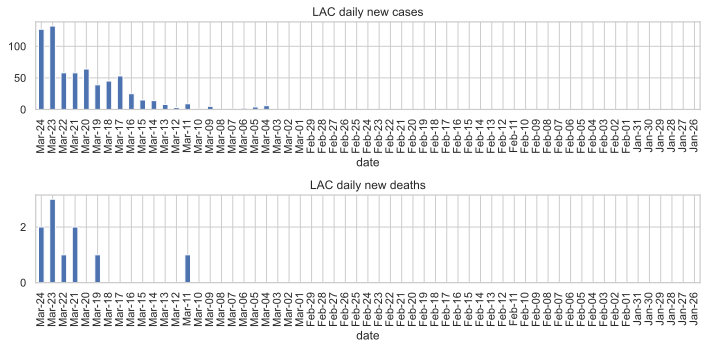

In [16]:

fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
lac_daily_new.new_confirmed_cases.plot(kind='bar', title="LAC daily new cases", ax=axes[0])
lac_daily_new.new_deaths.plot(kind='bar', title="LAC daily new deaths", ax=axes[1])
ticklabels = [i.strftime("%b-%d") for i, row in lac_daily_new.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
# axes[2].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
# axes[3].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
# axes[0].axhline(y=1, color='r')
# axes[1].axhline(y=1, color='r')
# axes[2].axhline(y=1, color='r')
# axes[3].axhline(y=1, color='r')
# fig.autofmt_xdate(); 
fig.tight_layout()
# fig.tight_layout()

# fig.autofmt_xdate(); 

In [17]:
print(f'ran at {datetime.datetime.isoformat(datetime.datetime.now())}')


ran at 2020-06-12T13:59:37.060959


In [ ]:
# Loop the downloader for every 24 hours
from time import sleep
day_seconds = 86400

while True:
    lac_data, local_data = download_data()
    print(f'ran at {datetime.datetime.now()}' )
    sleep(day_seconds)

# Counts

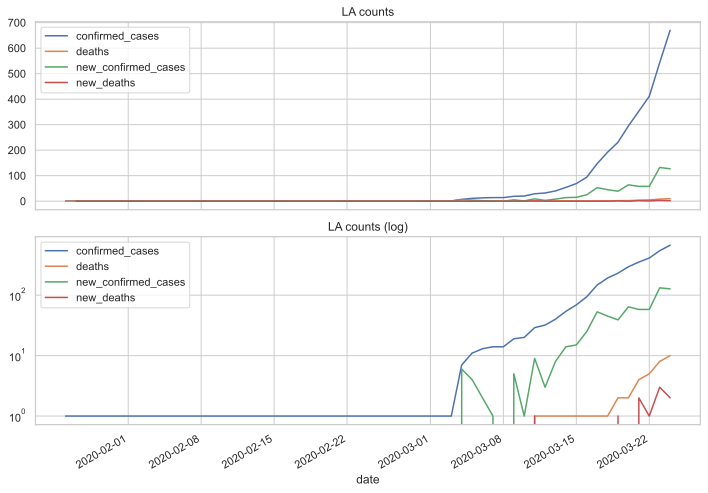

In [18]:
fig, axes = plt.subplots(nrows=2, figsize=(10,7))
lac.plot(x_compat=True, title="LA counts", ax=axes[0])
lac.plot(logy=True,  x_compat=True, title="LA counts (log)", ax=axes[1])
fig.autofmt_xdate()
fig.tight_layout()

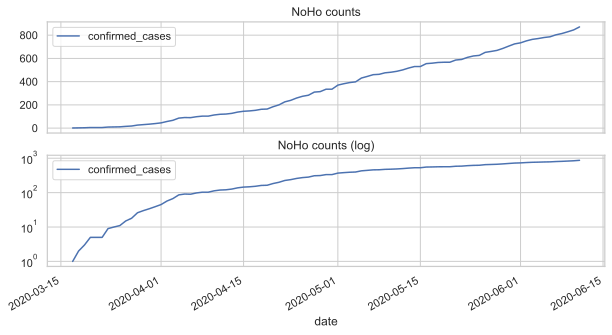

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(10,5))
noho.plot(   x_compat=True, title="NoHo counts", ax=axes[0])
noho.plot(logy=True,  x_compat=True, title="NoHo counts (log)", ax=axes[1])
fig.autofmt_xdate()

In [ ]:
df = lac_daily_new
TOOLTIPS = [
    ("new_confirmed_cases", "$index"),
    ("(x,y)", "($x, $y)"),
#     ("desc", "@desc"),
]

p = figure(plot_width=1000, 
           plot_height=400, 
           title="Daily new cases (LAC)", 
           x_axis_type='datetime')#, 
#            tooltips=TOOLTIPS)

source = ColumnDataSource(df.reset_index())
source2 = ColumnDataSource(df.rolling(window='7D').mean().reset_index())

# add a circle renderer with a size, color, and alpha
# p.circle(x='date', y='new_confirmed_cases', size=10, color="navy", source=source, alpha=0.5)
p.vbar(x='date', 
       top='new_confirmed_cases',  
       color="green", 
       width=0.4, 
       source=source, alpha=0.8, 
       legend_label='Daily new cases')
p.line(x='date', 
       y='new_confirmed_cases', 
       line_width=5, 
       color="navy", 
       source=source2, 
       alpha=0.3, 
       legend_label='7-day rolling avg')


# df['lower'] = df.new_confirmed_cases.mean() - df.new_confirmed_cases.std()
# df['upper'] = df.new_confirmed_cases.mean() + df.new_confirmed_cases.std()
# band = Band(base='x', lower='lower', upper='upper', source=source, level='underlay',
#             fill_alpha=1.0, line_width=1, line_color='black')
# p.add_layout(band)

# show the results
show(p)

# Growth rate (prev day new cases / current day new cases)

In [20]:
lac_new = lac - lac.shift(1)
lac_growth_rate = lac_new / lac_new.shift(1)

noho_new = noho - noho.shift(1)
noho_growth_rate = noho_new / noho_new.shift(1)

## LAC growth rate

AttributeError: 'DataFrame' object has no attribute 'cases'

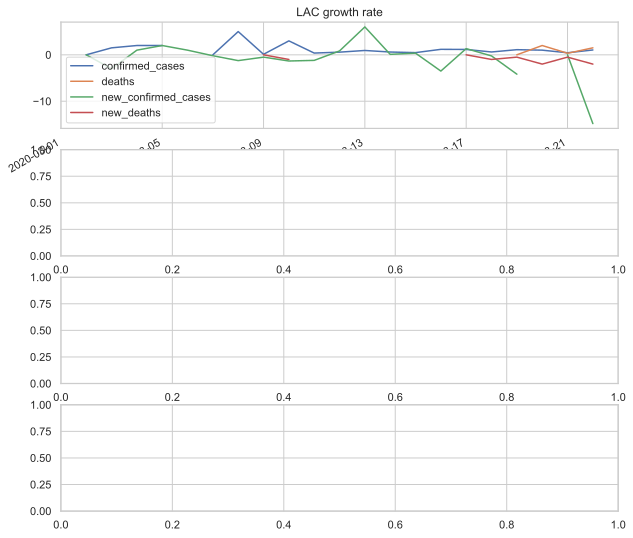

In [21]:
fig, axes = plt.subplots(nrows=4, figsize=(10,10))
lac_growth_rate.plot(x_compat=True, title="LAC growth rate", ax=axes[0])
lac_growth_rate.cases.plot( title="LAC growth rate cases", kind='bar', ax=axes[1])
lac_growth_rate.hospitalized.plot( title="LAC growth rate hospitalized", kind='bar', ax=axes[2])
lac_growth_rate.deaths.plot( title="LAC growth rate deaths", kind='bar', ax=axes[3])
ticklabels = [i.strftime("%b-%d") for i, row in lac_growth_rate.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[2].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[3].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[0].axhline(y=1, color='r')
axes[1].axhline(y=1, color='r')
axes[2].axhline(y=1, color='r')
axes[3].axhline(y=1, color='r')
fig.autofmt_xdate(); fig.tight_layout()

## NoHo growth

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10,5))
noho_growth_rate.plot(x_compat=True, title="NoHo Daily growth rate", ax=axes[0])
noho_growth_rate.plot( title="NoHo Daily growth rate", kind='bar', ax=axes[1])
ticklabels = [i.strftime("%b-%d") for i, row in noho_new.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[0].axhline(y=1, color='r')
axes[1].axhline(y=1, color='r')
fig.autofmt_xdate(); fig.tight_layout()

# Cumulative data

## Case and death counts

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(10,5))
lac_cum.confirmed_cases.plot(   x_compat=True, title="LAC cumulative counts (log)", ax=axes[0])
lac_cum.deaths.plot(   x_compat=True, title="LAC cumulative deaths (log)", ax=axes[1])
noho.confirmed_cases.plot(logy=True,  x_compat=True, title="NoHo cumulative counts (log)", ax=axes[2])
fig.autofmt_xdate(); fig.tight_layout()

## Hospitalizations

In [ ]:
fig, axes = plt.subplots(figsize=(10, 4))
hosp_lac.plot(title='Hospitalizations (LAC)', ax=axes )
fig.autofmt_xdate();
fig.tight_layout()

In [ ]:
df.set_index('date').new_deaths.resample('3D').mean()

In [ ]:
hosp_lac

# Daily new cases

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(10,10))
lac_new.plot(x_compat=True, title="LAC Daily new", ax=axes[0])
lac_new.cases.plot( title="LAC Daily new cases", kind='bar', ax=axes[1])
lac_new.hospitalized.plot( title="LAC Daily new hospitalized", kind='bar', ax=axes[2])
lac_new.deaths.plot( title="LAC Daily new deaths", kind='bar', ax=axes[3])
ticklabels = [i.strftime("%b-%d") for i, row in lac_new.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[2].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[3].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
fig.autofmt_xdate(); fig.tight_layout()

In [ ]:
lac_new.rolling(window=4).mean().plot()

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10,5))
noho_new.plot(x_compat=True, title="NoHo Daily new", ax=axes[0])
noho_new.plot( title="NoHo Daily new", kind='bar', ax=axes[1])
ticklabels = [i.strftime("%b-%d") for i, row in noho_new.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
fig.autofmt_xdate(); fig.tight_layout()

In [ ]:
# noho_growth_rate.rolling(window=4).mean().plot()

# Percent change from previous day

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
lac_growth.plot(kind='bar', title='LA % change',  ax=axes[0])
noho_growth.plot(kind='bar', title='NoHo % change',  ax=axes[1])
ticklabels = [i.strftime("%b-%d") for i, row in lac_growth.iterrows()]
axes[0].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[1].xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
axes[0].set_ylim((0,1.2)); axes[1].set_ylim((0,1.2))
fig.autofmt_xdate(); fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
lac_growth.plot(x_compat=True, title='LA % change',  ax=axes[0])
noho_growth.plot(x_compat=True, title='NoHo % change',  ax=axes[1])
axes[0].set_ylim((-1,1.2)); axes[1].set_ylim((-1,1.2))
fig.tight_layout()

# Data
## LA County
### Cases (counts)

In [ ]:
lac

### Hospitalizations

In [ ]:
hosp_lac

### Daily new 

In [ ]:
lac_new

In [ ]:
lac_daily_new

### Growth rate (ratio of day's growth to previous day's growth)

In [ ]:
lac_growth_rate

### Pct change from previous day)

In [ ]:
lac_growth.dropna(how='all')

## North Hollywood
### Cases (count)

In [ ]:
noho

In [ ]:
noho

### Daily new cases

In [ ]:
noho_new

### Growth rate (prev day new cases / current day new cases)

In [ ]:
noho_growth_rate

### Pct change from previous day

In [ ]:
noho_growth

# Attic

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
lac.plot(x_compat=True, title="LA counts", ax=axes[0, 0])
lac.plot(logy=True,  x_compat=True, title="LA counts (log)", ax=axes[0, 1])
noho.plot(   x_compat=True, title="NoHo counts", ax=axes[1,0])
noho.plot(logy=True,  x_compat=True, title="NoHo counts (log)", ax=axes[1,1])
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))
noho.plot(logy=True,  x_compat=True, title="NoHo counts (log)", ax=axes)
# axes.set_xlim('2020-03-20', '2020-04-01')


In [ ]:
DATAFOLDER = "{}/Dropbox/local-covid/data".format(ROOT)
datafile = "{}/covid.xlsx".format(DATAFOLDER)

# Load data
lac = pd.read_excel(datafile, sheet_name='lac')
lac.set_index('date', inplace=True)
lac_growth = lac.pct_change()
old_noho = pd.read_excel(datafile, sheet_name='noho')
# old_noho.set_index('date', inplace=True)
# noho_growth = old_noho.pct_change()

In [ ]:
import numpy as np

growth_rate = np.exp(np.diff(np.log(lac.cases))) - 1

In [ ]:
growth_rate

In [ ]:
r = requests.get(url)

In [ ]:
# Download and save new data

pd.options.display.max_rows = 999

URL = 'http://publichealth.lacounty.gov/media/Coronavirus/locations.htm'

def download_data(url=URL):
    data = pd.read_html(url)[0]
    # save copy
    data.to_csv(make_data_filepath(ORIGINAL_NAME_STEM))
    data.rename({'Locations' : 'location', 'Total Cases': 'cases'}, inplace=True, axis=1)
    # Get rid of empty rows
    data = data[~pd.isnull(data.location)]

    exclude = ['*']
    def process_strings(field):
        if not isinstance(field, str):
            return field
        if field == '--':
            return None
        return ''.join([a for a in field if a not in exclude])

    data.location = data.apply(lambda x : process_strings(x.location), axis=1)
    data.cases = data.apply(lambda x : process_strings(x.cases), axis=1)
    # have to process before cast because some rows will have things like 5****
    data.cases = data.cases.astype(float)
    data['date'] = datetime.datetime.now()

    # Extract the locality data
    try:
        city_start_idx = data.loc[data.location == 'CITY/COMMUNITY'].index[0]
    except IndexError:
        city_start_idx = data.loc[data.location == 'CITY / COMMUNITY'].index[0]
    lac_data = data[ : city_start_idx - 1 ]
    local_data = data[city_start_idx + 1 : ]

    # Save the data
    lac_data.to_csv(make_data_filepath(COUNTY_NAME_STEM))
    local_data.to_csv(make_data_filepath(LOCALITY_NAME_STEM))
    
    # Shouldn't need these since will be easier to just load all files
    return (lac_data, local_data)
lac_data, local_data = download_data()

In [ ]:
# Load existing
local_fit = make_data_fiterator(LOCALITY_NAME_STEM)
county_fit = make_data_fiterator(COUNTY_NAME_STEM)

old_lac = pd.read_excel(datafile, sheet_name='lac')
old_noho = pd.read_excel(datafile, sheet_name='noho')

lac_data = pd.concat([pd.read_csv(df).set_index('date').drop(['Unnamed: 0'], axis=1) for df in county_fit])

local = pd.concat([pd.read_csv(df).set_index('date').drop(['Unnamed: 0'], axis=1) for df in local_fit])
local.index = pd.to_datetime(local.index)

# NoHo data
noho_names = ['Los Angeles - North Hollywood']
local.reset_index(inplace=True)
noho = local[local.location.isin(noho_names)][['cases', 'date']]
# add in old data
noho = pd.concat([noho, old_noho])
noho.set_index('date', inplace=True)
# Fix day where less cases reported than day before
noho.loc['2020-04-06', 'cases'] = 91
noho.sort_index(inplace=True)
noho_growth = noho.pct_change()
# noho

# Extract cases, deaths, hospitalizations for county
lac_names = {'Laboratory Confirmed Cases (LCC)': 'cases',
 'Deaths': 'deaths',
    'Hospitalized (Ever)' : 'hospitalized' }

dlac = lac_data[lac_data.location.isin(lac_names.keys())]
dlac = dlac.pivot(columns='location', values='cases')
dlac.rename(lac_names, axis=1, inplace=True)
dlac.reset_index(inplace=True)
# dlac.set_index('date')
# dlac.drop(['location'], axis=1, inplace=True)

# dlac

# dlac.reset_index(inplace=True)
lac = pd.concat([dlac, old_lac])
lac.date = pd.to_datetime(lac.date)
lac.set_index('date', inplace=True)
# lac.drop(['level_0'], axis=1, inplace=True)
lac.sort_index(inplace=True)
# lac
lac_growth = lac.pct_change()


In [ ]:
COUNTY_NAME_STEM = "la_county_data.csv"
LOCALITY_NAME_STEM = "locality_data.csv"
ORIGINAL_NAME_STEM = "original_data.csv"

def make_data_filepath(name_stem):
    dt = datetime.date.isoformat( datetime.date.today() )
    return "{}/{}_{}".format(DATAFOLDER, dt, name_stem)



def make_data_fiterator( name_stem, data_folder=DATAFOLDER ):
    """
    Returns an iterator of all files with the name stem
    in the source directory such that each file has its path appended to it.

    Args:
        folderPath: The path to get file names from
        exclude: file names which should not be included in the output list

    """
    for root, dirs, files in os.walk( data_folder ):
        for name in files:
            if name[ -len(name_stem): ] == name_stem:
                yield os.path.join( root, name )


In [ ]:
# fixing missed day
local_data.date = local_data.date - pd.Timedelta('1 day')
local_data

local_data.to_csv(make_data_filepath(LOCALITY_NAME_STEM))

In [ ]:
import requests

In [ ]:
r.content

In [ ]:
old_lac

In [ ]:
lac.pivot()

In [ ]:
local

In [ ]:
f = make_locality_filepath()

f[ -len(LOCALITY_NAME_STEM):] == LOCALITY_NAME_STEM

In [ ]:
dlac.index

In [ ]:
local_data

In [ ]:
data

In [ ]:
noho

In [ ]:
soup = BeautifulSoup( r.content, features="lxml" )


In [ ]:
soup.table

https://www.latimes.com/projects/california-coronavirus-cases-tracking-outbreak/
    
    Data inside a script tag at the bottom of the page

In [ ]:
window.STATEWIDE_TIMESERIES = [{"date":"2020-01-26","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":null,"new_deaths":null},{"date":"2020-01-27","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-28","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-29","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-30","confirmed_cases":2,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-01-31","confirmed_cases":3,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-01","confirmed_cases":3,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-02","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":3,"new_deaths":0},{"date":"2020-02-03","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-04","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-05","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-06","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-07","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-08","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-09","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-10","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-11","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-12","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-13","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-14","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-15","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-16","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-17","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-18","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-19","confirmed_cases":6,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-20","confirmed_cases":7,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-21","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-22","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-23","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-24","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-25","confirmed_cases":8,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-26","confirmed_cases":9,"deaths":0,"in_progress":false,"new_confirmed_cases":1,"new_deaths":0},{"date":"2020-02-27","confirmed_cases":9,"deaths":0,"in_progress":false,"new_confirmed_cases":0,"new_deaths":0},{"date":"2020-02-28","confirmed_cases":11,"deaths":0,"in_progress":false,"new_confirmed_cases":2,"new_deaths":0},{"date":"2020-02-29","confirmed_cases":13,"deaths":0,"in_progress":false,"new_confirmed_cases":2,"new_deaths":0},{"date":"2020-03-01","confirmed_cases":18,"deaths":0,"in_progress":false,"new_confirmed_cases":5,"new_deaths":0},{"date":"2020-03-02","confirmed_cases":23,"deaths":0,"in_progress":false,"new_confirmed_cases":5,"new_deaths":0},{"date":"2020-03-03","confirmed_cases":30,"deaths":0,"in_progress":false,"new_confirmed_cases":7,"new_deaths":0},{"date":"2020-03-04","confirmed_cases":40,"deaths":1,"in_progress":false,"new_confirmed_cases":10,"new_deaths":1},{"date":"2020-03-05","confirmed_cases":54,"deaths":1,"in_progress":false,"new_confirmed_cases":14,"new_deaths":0},{"date":"2020-03-06","confirmed_cases":70,"deaths":1,"in_progress":false,"new_confirmed_cases":16,"new_deaths":0},{"date":"2020-03-07","confirmed_cases":90,"deaths":1,"in_progress":false,"new_confirmed_cases":20,"new_deaths":0},{"date":"2020-03-08","confirmed_cases":101,"deaths":1,"in_progress":false,"new_confirmed_cases":11,"new_deaths":0},{"date":"2020-03-09","confirmed_cases":142,"deaths":2,"in_progress":false,"new_confirmed_cases":41,"new_deaths":1},{"date":"2020-03-10","confirmed_cases":153,"deaths":3,"in_progress":false,"new_confirmed_cases":11,"new_deaths":1},{"date":"2020-03-11","confirmed_cases":183,"deaths":4,"in_progress":false,"new_confirmed_cases":30,"new_deaths":1},{"date":"2020-03-12","confirmed_cases":237,"deaths":4,"in_progress":false,"new_confirmed_cases":54,"new_deaths":0},{"date":"2020-03-13","confirmed_cases":301,"deaths":5,"in_progress":false,"new_confirmed_cases":64,"new_deaths":1},{"date":"2020-03-14","confirmed_cases":371,"deaths":5,"in_progress":false,"new_confirmed_cases":70,"new_deaths":0},{"date":"2020-03-15","confirmed_cases":440,"deaths":6,"in_progress":false,"new_confirmed_cases":69,"new_deaths":1},{"date":"2020-03-16","confirmed_cases":571,"deaths":12,"in_progress":false,"new_confirmed_cases":131,"new_deaths":6},{"date":"2020-03-17","confirmed_cases":729,"deaths":14,"in_progress":false,"new_confirmed_cases":158,"new_deaths":2},{"date":"2020-03-18","confirmed_cases":869,"deaths":17,"in_progress":false,"new_confirmed_cases":140,"new_deaths":3},{"date":"2020-03-19","confirmed_cases":1040,"deaths":19,"in_progress":false,"new_confirmed_cases":171,"new_deaths":2},{"date":"2020-03-20","confirmed_cases":1247,"deaths":24,"in_progress":false,"new_confirmed_cases":207,"new_deaths":5},{"date":"2020-03-21","confirmed_cases":1506,"deaths":28,"in_progress":false,"new_confirmed_cases":259,"new_deaths":4},{"date":"2020-03-22","confirmed_cases":1802,"deaths":35,"in_progress":false,"new_confirmed_cases":296,"new_deaths":7},{"date":"2020-03-23","confirmed_cases":2222,"deaths":43,"in_progress":false,"new_confirmed_cases":420,"new_deaths":8},{"date":"2020-03-24","confirmed_cases":2621,"deaths":54,"in_progress":false,"new_confirmed_cases":399,"new_deaths":11},{"date":"2020-03-25","confirmed_cases":3244,"deaths":69,"in_progress":false,"new_confirmed_cases":623,"new_deaths":15},{"date":"2020-03-26","confirmed_cases":4055,"deaths":83,"in_progress":false,"new_confirmed_cases":811,"new_deaths":14},{"date":"2020-03-27","confirmed_cases":2929,"deaths":57,"in_progress":true,"new_confirmed_cases":-1126,"new_deaths":-26}];

In [ ]:
url = 'https://www.latimes.com/projects/california-coronavirus-cases-tracking-outbreak/'
r = requests.get(url)

In [ ]:
days = [i for i in range(1, 6)]
wkdays = lac_daily_new[lac_daily_new.index.weekday.isin(days)]

df = wkdays.reset_index()
p = figure(plot_width=1000, plot_height=400, title="Daily new cases (LAC) -- Tuesday-Saturday only", x_axis_type='datetime')
source = ColumnDataSource(df)
p.vbar(x='date', top='new_confirmed_cases',  color="navy", width=0.4, source=source, alpha=0.8)
show(p)